In [1]:
library(Seurat)
library(Matrix)
library(stringr)
library(ggplot2)
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(topGO)
library(plyr)
library(igraph)
library(networkD3)
library(ggrepel)
library(magrittr)
library(dplyr)
library(EnsDb.Hsapiens.v79)
library(mygene)
library(org.Hs.eg.db)
library(GeneBook)
library(UniProt.ws)
library(robustbase)
library(PerformanceAnalytics)
library(factoextra)
library(EnsDb.Hsapiens.v79)
library(mygene)
library(org.Hs.eg.db)
library(GeneBook)
library(UniProt.ws)
library(ggpubr)
library(gridExtra)
library(cowplot)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github pag

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:Biobase':

    combine

The following object is masked from 'package:BiocGenerics':

    combine


Attaching package: 'cowplot'

The following object is masked from 'package:ggpubr':

    get_legend



In [2]:
font_size <- 12
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3

In [3]:
sample_info <- read.table("/Users/zhangmeng/ownCloud/Meng/ROSMAP/metadata/ROSMAP_clinical.csv", sep=",",
                          head = TRUE, stringsAsFactors = FALSE)

In [4]:
#subset(sample_info, individualID %in% sample_info_for_Ex$individualID)

In [6]:
load(file = "somatic_sample_info.Rdata")

In [7]:
somatic_samples$sex <- sapply(somatic_samples$individualID, function(x){
    return(sample_info[which(sample_info$individualID == x), ]$msex)
})

somatic_samples$educ <- sapply(somatic_samples$individualID, function(x){
    return(sample_info[which(sample_info$individualID == x), ]$educ)
})

somatic_samples$CERAD <- sapply(somatic_samples$individualID, function(x){
    return(sample_info[which(sample_info$individualID == x), ]$ceradsc)
})

somatic_samples$apoe <- sapply(somatic_samples$individualID, function(x){
    return(sample_info[which(sample_info$individualID == x), ]$apoe_genotype)
})

In [10]:
load(file = "All_sample_cell_number.Rdata")

In [12]:
plot_cell <- data.frame(IID = rep(rownames(All_sample_cell_number), ncol(All_sample_cell_number)-1),
                        count = unlist(All_sample_cell_number[, 1:7]),
                        type = rep(colnames(All_sample_cell_number)[1:7], each=nrow(All_sample_cell_number)),
                        study = rep(All_sample_cell_number$study, ncol(All_sample_cell_number)-1), 
                        stringsAsFactors = FALSE)

In [14]:
plot_data <- plot_cell

pdf("Plot_out/ALLsample_allcell_num_plot.pdf", width=10, height=5)
plot_data$IID <- factor(plot_data$IID, level=somatic_samples$individualID)
ggplot(data=plot_data, 
       aes(x=IID, y=count, fill=as.factor(type))) +
  geom_bar(aes(color = as.factor(study)), stat="identity")+
  xlab("Sample ID") + ylab("Number of cells") +
  #geom_hline(yintercept=200, linetype='dotted', col = 'red', size=1)+
  scale_fill_brewer(name="Cell type", palette="Paired") +
  scale_color_manual(name="Study", values = c("blue", "red", "orange", "purple"), 
                    breaks = c("B1", "B2", "BA10", "TREM2")) + 
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
dev.off()

pdf 
  2

In [16]:
somatic_samples$Ex <- All_sample_cell_number$Ex

In [17]:
sample_info_for_Ex <- subset(somatic_samples,
                             (Ex > 200) & (Tread_num > 6*10^7) & (individualID !="R6411801"))

In [20]:
summary(subset(sample_info_for_Ex, cogdx == 1)$age)
summary(subset(sample_info_for_Ex, cogdx == 4)$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   76.0    84.0    86.0    85.7    90.0    90.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  74.00   85.00   89.00   87.12   90.00   90.00 

In [21]:
Exsample_readcount <- read.table(file="read_number_Exsample.txt", header=TRUE)

In [23]:
sample_info_for_Ex$read4Ex <- Exsample_readcount$readcount

In [32]:
somatic_samples$individualID <- factor(somatic_samples$individualID, levels = somatic_samples$individualID)

pdf("Plot_out/ALLsample_totalread_num_plot.pdf", width=10, height=5)
ggplot(data=somatic_samples, aes(x=individualID, y=Tread_num, fill=as.factor(study))) +
  geom_bar(stat="identity")+
  xlab("Sample ID") + ylab("Total number of read") +
  scale_fill_manual(name="Study", values = c("blue", "red", "orange", "purple"), 
                    breaks = c("B1", "B2", "BA10", "TREM2")) + 
  geom_hline(yintercept=6*10^7, linetype='dotted', col = 'red', size=1)+

  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
dev.off()


pdf 
  2

In [34]:
sample_info_for_Ex$individualID <- factor(sample_info_for_Ex$individualID, levels = sample_info_for_Ex$individualID)

pdf("Plot_out/ALLsample_total_Exread_num_plot.pdf", width=10, height=5)
ggplot(data=sample_info_for_Ex, aes(x=individualID, y=read4Ex, fill=as.factor(study))) +
  geom_bar(stat="identity")+
  xlab("Sample ID") + ylab("Total number of read") +
  scale_fill_manual(name="Study", values = c("blue", "red", "orange", "purple"), 
                    breaks = c("B1", "B2", "BA10", "TREM2")) + 
  #geom_hline(yintercept=6*10^7, linetype='dotted', col = 'red', size=1)+

  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
dev.off()

pdf 
  2

In [35]:
sample_info_for_Ex$scaler <- sample_info_for_Ex$read4Ex/(mean(sample_info_for_Ex$read4Ex))

In [36]:
bulkbrain_variant_ann <- fread("Ex76_selectedVCF_dropGT_ALLchr_GENE.tsv",
                          header = TRUE, sep = "\t", fill = TRUE) %>% as.data.frame()
colnames(bulkbrain_variant_ann) <- c("CHROM", "POS", "REF", "ALT", "ANN.EFFECT", "ANN.GENE")

In [38]:
bulkbrain_variant_ann$EFFECT <- sapply(bulkbrain_variant_ann$ANN.EFFECT, function(x){
    return(unlist(str_split(x, ","))[1])
})
bulkbrain_variant_ann$GENE <- sapply(bulkbrain_variant_ann$ANN.GENE, function(x){
    return(unlist(str_split(x, ","))[1])
})

In [39]:
bulkbrain_variant_ann$ID <- apply(bulkbrain_variant_ann, 1, function(x){
    return(gsub(" ", "", paste(x[1], x[2], sep=':')))
}) 

In [40]:
load(file="Ex76_read_count_matrixs_gD10_addWGS.Rdata")

In [43]:
bulkbrain_variant_ann <- bulkbrain_variant_ann[which(bulkbrain_variant_ann$ID %in% as.character(read_count_matrixs[[1]]$POS)), ]

In [45]:
count_read <- NULL

In [46]:
for(i in 1:length(read_count_matrixs)){
    count_read <- cbind(count_read, read_count_matrixs[[i]]$sum)
}

[1] 9991


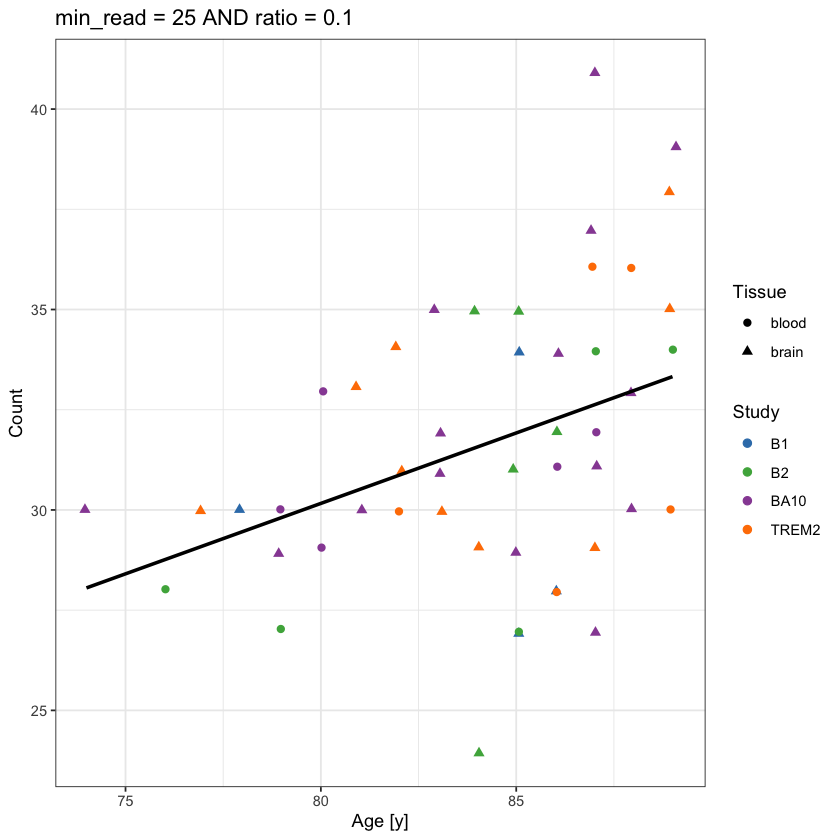

In [61]:
min_read = 25
ratio = 0.1

cutoff <- NULL
for(id in 1:nrow(sample_info_for_Ex)){
    cutoff <- cbind(cutoff, rep(sample_info_for_Ex[id, ]$scaler * min_read, nrow(count_read)))
}

cout_g20_matrix <- data.frame(count = rowSums(count_read >= cutoff))

cout_g20_matrix$ratio <- cout_g20_matrix$count / ncol(count_read)
cout_g20_matrix$keep <- cout_g20_matrix$ratio == 1

print(sum(cout_g20_matrix$keep))

ref2alt_ratio_matrix <- sapply(1:length(read_count_matrixs), function(x){
    read_count_matrixs[[x]]$keep <- cout_g20_matrix$keep
    read_matrix <- subset(read_count_matrixs[[x]], (WGS == 1)&(keep))
    #print(head(gt_matrix))
    count <- sum(((read_matrix$alt / (read_matrix$alt + 
                                           read_matrix$ref)) >= ratio) &
                 ((read_matrix$alt + read_matrix$ref) >= sample_info_for_Ex[x, ]$scaler * min_read), 
                 na.rm=TRUE)
    return(count)
}) 
#print(ref2alt_ratio_matrix)


alt2ref_ratio_matrix <- sapply(1:length(read_count_matrixs), function(x){
    read_count_matrixs[[x]]$keep <- cout_g20_matrix$keep
    read_matrix <- subset(read_count_matrixs[[x]], (WGS == 2)&(keep))
    #print(head(gt_matrix))
    count <- sum(((read_matrix$ref / (read_matrix$alt + 
                                           read_matrix$ref)) >= ratio) &
                 ((read_matrix$alt + read_matrix$ref) >= sample_info_for_Ex[x, ]$scaler * min_read), 
                 na.rm=TRUE)
    return(count)
})

count2_matrix <- data.frame(IID=names(read_count_matrixs), count = alt2ref_ratio_matrix + 
                            ref2alt_ratio_matrix, stringsAsFactors = FALSE)

count2_matrix$age <- sapply(count2_matrix$IID, function(x){
    return(somatic_samples[which(somatic_samples$individualID == x), ]$age)
})

count2_matrix$braak <- sapply(count2_matrix$IID, function(x){
    return(somatic_samples[which(somatic_samples$individualID == x), ]$braak)
})

count2_matrix$tissue <- sapply(count2_matrix$IID, function(x){
    return(somatic_samples[somatic_samples$individualID == x, ]$tissue)
})

count2_matrix$cogdx <- sapply(count2_matrix$IID, function(x){
    return(somatic_samples[which(somatic_samples$individualID == x), ]$cogdx)
})

count2_matrix$Tread_num <- sapply(count2_matrix$IID, function(x){
    return(somatic_samples[which(somatic_samples$individualID == x), ]$Tread_num)
})

count2_matrix$study <- sapply(count2_matrix$IID, function(x){
    return(somatic_samples[which(somatic_samples$individualID == x), ]$study)
})

#print(paste("min_read = ", min_read, "AND ratio = ", ratio, sep=""))

p1 <- ggplot(subset(count2_matrix, age < 90), aes(x=age, y=count, color=as.factor(study))) + 
    geom_jitter(aes(shape = tissue), size = 2, height = 0.1, width=0.1) +
    geom_smooth(method = "rlm", se=FALSE, color="black", formula = y~x, fullrange=TRUE) +
    ggtitle(paste("min_read = ", min_read, " AND ratio = ", ratio, sep="")) + 
    ylab("Count") + 
    xlab("Age [y]") +
    scale_colour_manual(name="Study", values = c('#377EB8', '#4DAF4A', '#984EA3', '#FF7F00')) + 
    scale_shape_manual(name="Tissue", values = c(16, 17)) +
    #ylim(-1, 11) +
    theme_bw()
print(p1)

In [69]:
min_read = 25
ratio = 0.1

cutoff <- NULL
for(id in 1:nrow(sample_info_for_Ex)){
    cutoff <- cbind(cutoff, rep(sample_info_for_Ex[id, ]$scaler * min_read, nrow(count_read)))
}

cout_gD_matrix <- data.frame(count = rowSums(count_read >= cutoff))

cout_gD_matrix$ratio <- cout_gD_matrix$count / ncol(count_read)
cout_gD_matrix$keep <- cout_gD_matrix$ratio == 1

print(sum(cout_gD_matrix$keep))

[1] 9991


In [70]:
for(i in 1:length(read_count_matrixs)){
    read_count_matrixs[[i]]$has_mutation <- 0
    
    ref2alt_idx <- which((read_count_matrixs[[i]]$WGS == 1) & (cout_gD_matrix$keep) & 
      ((read_count_matrixs[[i]]$alt / (read_count_matrixs[[i]]$alt + 
                                            read_count_matrixs[[i]]$ref)) >= ratio) )
    
    alt2ref_idx <- which((read_count_matrixs[[i]]$WGS == 2) & (cout_gD_matrix$keep) & 
      ((read_count_matrixs[[i]]$ref / (read_count_matrixs[[i]]$alt + 
                                            read_count_matrixs[[i]]$ref)) >= ratio) )
    
    if(length(c(ref2alt_idx, alt2ref_idx)) != 0){
        read_count_matrixs[[i]][c(ref2alt_idx, alt2ref_idx), ]$has_mutation <- 1
    }
}

In [71]:
gene_sample_mutation <- NULL
for(i in 1:length(read_count_matrixs)){
    gene_sample_mutation <- cbind(gene_sample_mutation, read_count_matrixs[[i]]$has_mutation)
}

In [72]:
rownames(gene_sample_mutation) <- read_count_matrixs[[1]]$POS
colnames(gene_sample_mutation) <- names(read_count_matrixs)

In [73]:
gene_mutation_sum <- rowSums(gene_sample_mutation)

In [74]:
sum(gene_mutation_sum != 0)

[1] 196

In [75]:
mutated_gene_sample <- cbind(bulkbrain_variant_ann[which(gene_mutation_sum != 0), ],
                             gene_sample_mutation[which(gene_mutation_sum != 0), ])

In [76]:
mutated_gene_sample$sum <- gene_mutation_sum[which(gene_mutation_sum != 0)]

In [77]:
POS_sample_mutation <- gene_sample_mutation[which(gene_mutation_sum != 0), ]

In [52]:
write.table(mutated_gene_sample[, c(1, 2)], file = "somatic_mutation_position.txt", sep = "\t", 
            col.names = FALSE, row.names = FALSE)

In [80]:
mutation_count_persample <- data.frame(ID = colnames(POS_sample_mutation), count = colSums(POS_sample_mutation), 
                                       stringsAsFactors = FALSE)

In [82]:
sample_info_for_Ex$count <- sapply(sample_info_for_Ex$individualID, function(x){
    return(mutation_count_persample[which(mutation_count_persample$ID ==x), ]$count)
})

In [87]:
summary(lm(count~age, subset(sample_info_for_Ex, age < 190)))


Call:
lm(formula = count ~ age, data = subset(sample_info_for_Ex, age < 
    190))

Residuals:
    Min      1Q  Median      3Q     Max 
-7.9471 -1.9471  0.0008  2.2404  9.4904 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) 18.82294    8.09998   2.324   0.0229 *
age          0.14582    0.09375   1.555   0.1241  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.336 on 74 degrees of freedom
Multiple R-squared:  0.03166,	Adjusted R-squared:  0.01857 
F-statistic: 2.419 on 1 and 74 DF,  p-value: 0.1241


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warn

"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"con

"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"con

"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"con

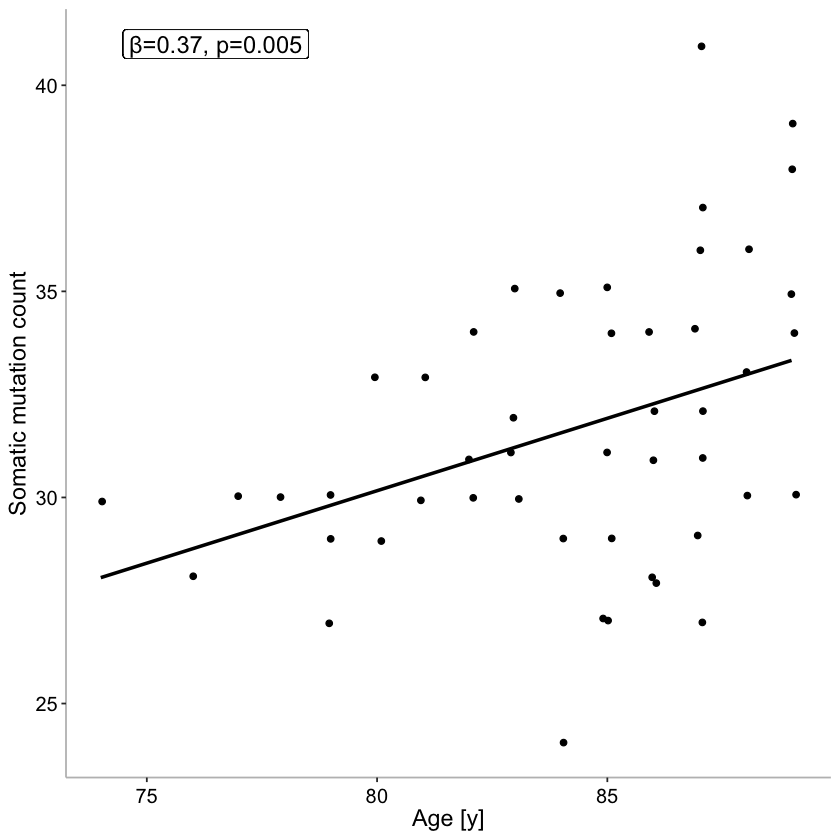

In [69]:
p_age <- ggplot(subset(sample_info_for_Ex, age != 90), aes(x=age, y=count)) + 
    geom_jitter(size = 1.5, height = 0.1, width=0.1) +
    geom_smooth(method = "rlm", se=FALSE, color="black", formula = y~x, fullrange=TRUE) +
    ylab("Somatic mutation count") + 
    xlab("Age [y]") +

    geom_label(aes(x=76.5, y=41, label="β=0.37, p=0.005"), 
               color="black", 
               size=5, angle=0) +

    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add*2#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size + font_size_add, color = "black"),
          
          axis.title.x = element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_age

In [70]:
save_plot("Somatic_mutation_count_vs_age_no90_plot.pdf", p_age, ncol = 1, base_height = 5, base_width = 5)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warn

"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, 

"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, 

"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"con

"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.37, p=0.005' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"con

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning me

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

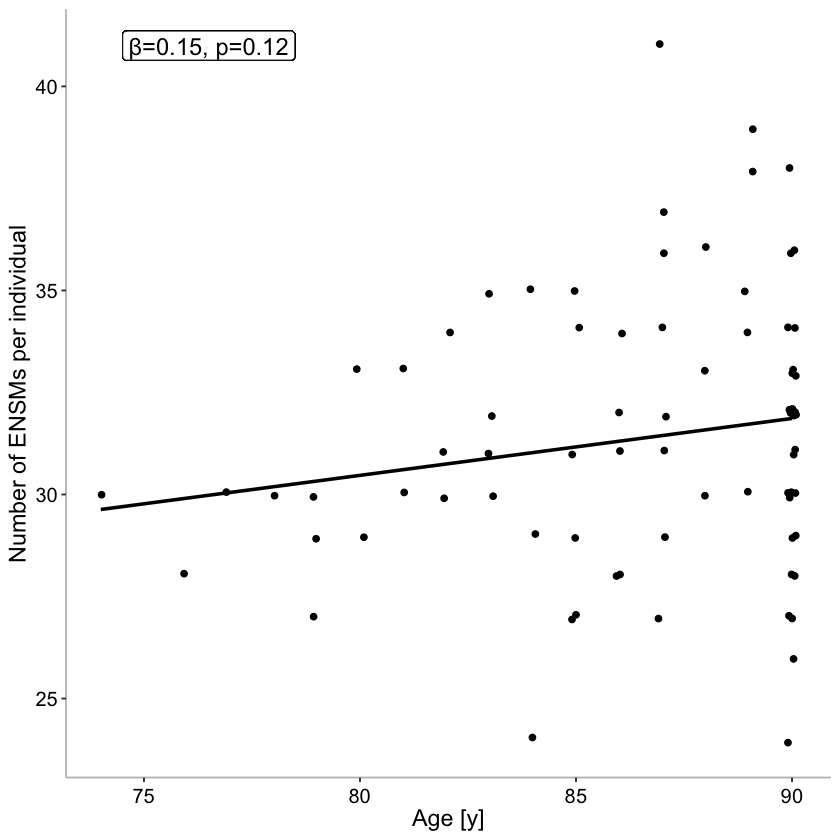

In [89]:
p_age <- ggplot(sample_info_for_Ex, aes(x=age, y=count)) + 
    geom_jitter(size = 1.5, height = 0.1, width=0.1) +
    geom_smooth(method = "rlm", se=FALSE, color="black", formula = y~x, fullrange=TRUE) +
    ylab("Number of ENSMs per individual") + 
    xlab("Age [y]") +

    geom_label(aes(x=76.5, y=41, label="β=0.15, p=0.12"), 
               color="black", 
               size=5, angle=0) +

    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add*2#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size + font_size_add, color = "black"),
          
          axis.title.x = element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_age

In [90]:
sample_info_for_Ex$group <- ""
sample_info_for_Ex[which(sample_info_for_Ex$cogdx %in% c(1, 2, 3)), ]$group <- "ND"
sample_info_for_Ex[which(sample_info_for_Ex$cogdx %in% c(4, 5)), ]$group <- "AD"
sample_info_for_Ex[which(sample_info_for_Ex$cogdx %in% c(6)), ]$group <- "Other"

In [91]:
sample_info_for_Ex$ADND <- NA
sample_info_for_Ex[sample_info_for_Ex$cogdx == 1, ]$ADND  <- "ND"
sample_info_for_Ex[sample_info_for_Ex$cogdx == 4, ]$ADND  <- "AD"

In [93]:
sample_info_for_Ex$group <- factor(sample_info_for_Ex$group, levels = c("ND", "AD", "Other"))

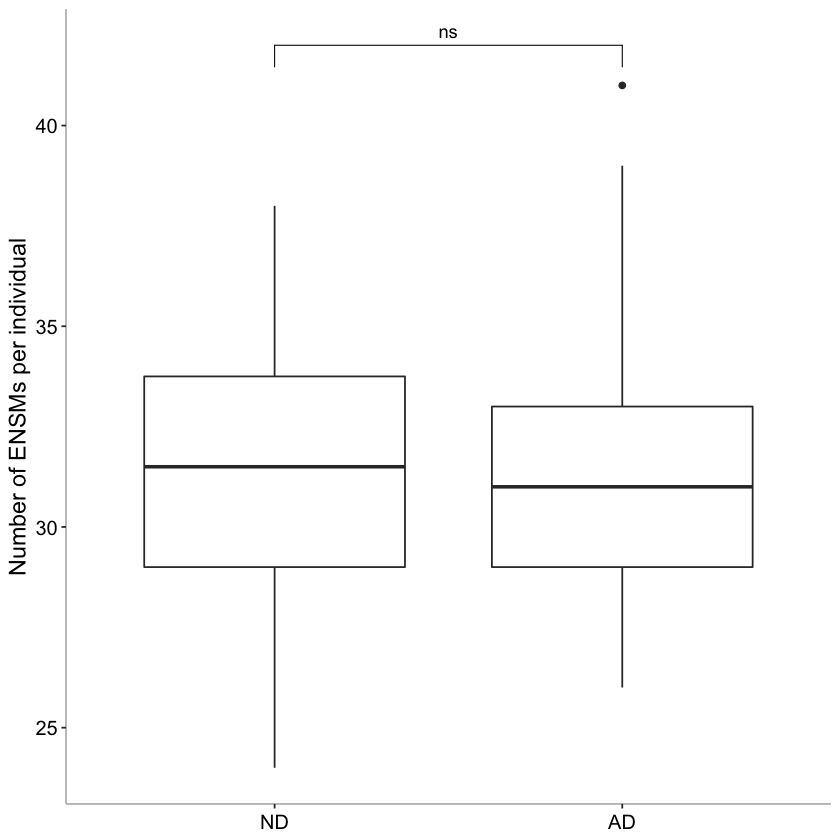

In [95]:
plot_table <- data.frame(`.y.` = "count",
                     group1 = "ND", 
                     group2 = "AD",
                     test_label = "ns")

plot_table$y.position <- 42

p_ADND <- ggplot(subset(sample_info_for_Ex, group != "Other"), aes(x=group, y=count)) + 
    geom_boxplot() +
    #geom_smooth(method = "rlm", se=FALSE, color="black", formula = y~x, fullrange=TRUE) +
    ylab("Number of ENSMs per individual") + 
    #xlab("Age [y]") +

    stat_pvalue_manual(plot_table, label = "test_label") +
    
    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add*2#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size + font_size_add, color = "black"),
          
          axis.title.x = element_blank(), #element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_ADND

In [98]:
wilcox.test(count~group, subset(sample_info_for_Ex, group != "Other"), paired = FALSE)

Warning message in wilcox.test.default(x = c(34, 30, 29, 28, 35, 33, 28, 38, 35, :
"cannot compute exact p-value with ties"


	Wilcoxon rank sum test with continuity correction

data:  count by group
W = 728.5, p-value = 0.7072
alternative hypothesis: true location shift is not equal to 0


In [103]:
SNV_plot <- plot_grid(p_age, p_ADND, 
          align = "hv", axis = "lr", 
          labels = c("A", "B"), label_size = 16, hjust = 0, vjust = 1,
          nrow = 1, ncol = 2)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning me

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

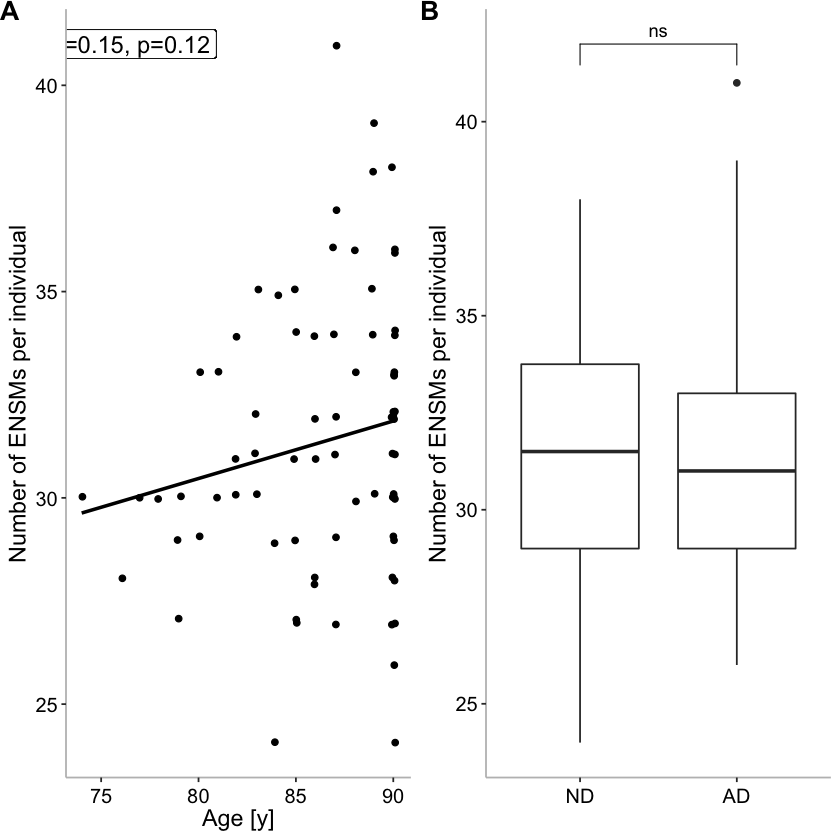

In [104]:
SNV_plot

In [105]:
save_plot("Plot_out/Somatic_mutation_count_plot_20221212.pdf", SNV_plot, ncol = 2, base_height = 5, base_width = 5)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning me

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"con

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"con

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"con

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <b2>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'β=0.15, p=0.12' in 'mbcsToSbcs': dot substituted for <ce>"Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversio

In [177]:
summary(lm(count~age, subset(sample_info_for_Ex, group == "AD")))


Call:
lm(formula = count ~ age, data = subset(sample_info_for_Ex, group == 
    "AD"))

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7450 -2.1353 -0.6475  1.2550  9.6208 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  20.7702    13.9047   1.494    0.145
age           0.1219     0.1594   0.765    0.450

Residual standard error: 3.549 on 31 degrees of freedom
Multiple R-squared:  0.01852,	Adjusted R-squared:  -0.01314 
F-statistic: 0.5849 on 1 and 31 DF,  p-value: 0.4502


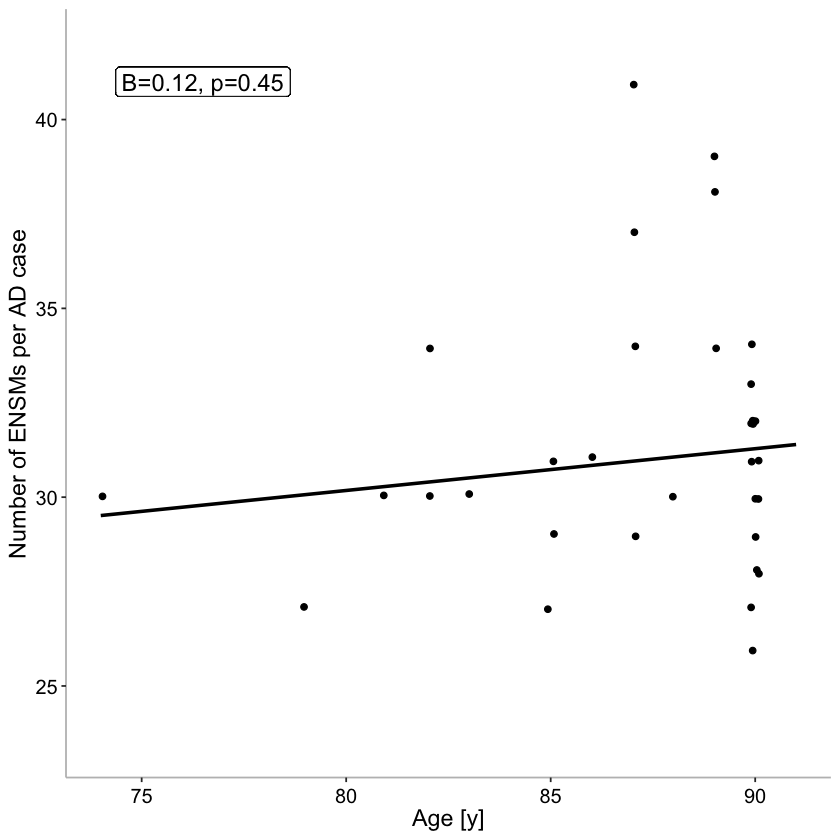

In [178]:
p_age_inAD <- ggplot(subset(sample_info_for_Ex, group == "AD"), aes(x=age, y=count)) + 
    geom_jitter(size = 1.5, height = 0.1, width=0.1) +
    geom_smooth(method = "rlm", se=FALSE, color="black", formula = y~x, fullrange=TRUE) +
    ylab("Number of ENSMs per AD case") + 
    xlab("Age [y]") +

    xlim(74, 91) +
    ylim(23.5, 42) +

    geom_label(aes(x=76.5, y=41, label="B=0.12, p=0.45"), 
               color="black", 
               size=5, angle=0) +

    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add*2#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size + font_size_add, color = "black"),
          
          axis.title.x = element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )

p_age_inAD

In [179]:
summary(lm(count~age, subset(sample_info_for_Ex, group == "ND")))


Call:
lm(formula = count ~ age, data = subset(sample_info_for_Ex, group == 
    "ND"))

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1259 -1.9926  0.2338  2.6004  5.8741 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  15.3884    10.2660   1.499    0.142
age           0.1860     0.1196   1.555    0.128

Residual standard error: 3.218 on 40 degrees of freedom
Multiple R-squared:  0.05701,	Adjusted R-squared:  0.03343 
F-statistic: 2.418 on 1 and 40 DF,  p-value: 0.1278


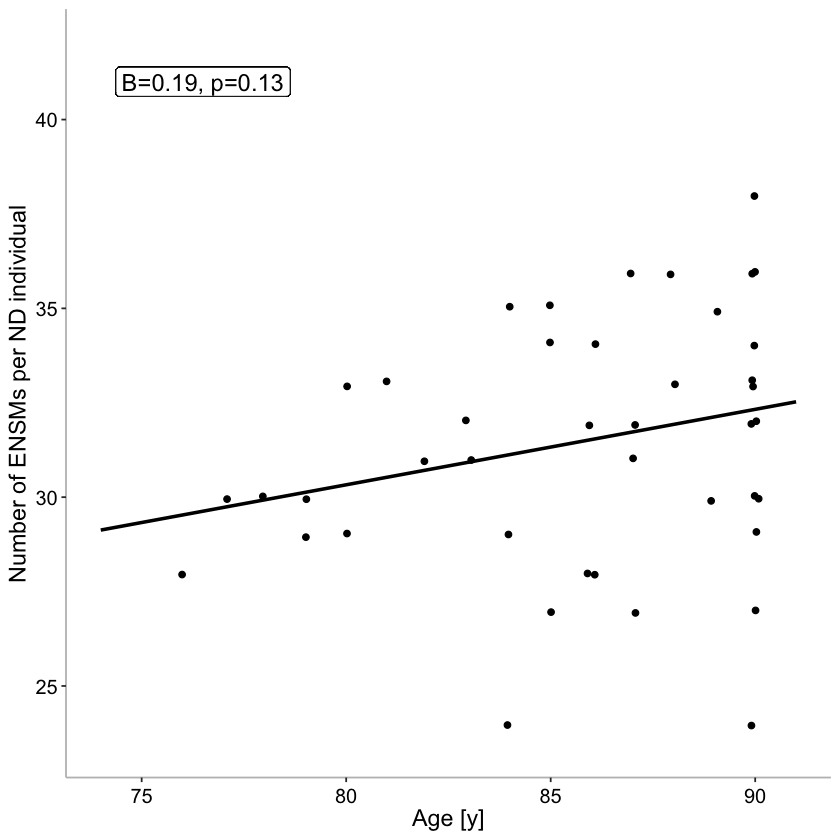

In [180]:
p_age_inND <- ggplot(subset(sample_info_for_Ex, group == "ND"), aes(x=age, y=count)) + 
    geom_jitter(size = 1.5, height = 0.1, width=0.1) +
    geom_smooth(method = "rlm", se=FALSE, color="black", formula = y~x, fullrange=TRUE) +
    ylab("Number of ENSMs per ND individual") + 
    xlab("Age [y]") +

    xlim(74, 91) +
    ylim(23.5, 42) +

    geom_label(aes(x=76.5, y=41, label="B=0.19, p=0.13"), 
               color="black", 
               size=5, angle=0) +

    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add*2#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size + font_size_add, color = "black"),
          
          axis.title.x = element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_age_inND

In [181]:
ENSM_vs_age_plots <- plot_grid(p_age_inAD, p_age_inND, 
          align = "hv", axis = "lr", 
          labels = c("A", "B"), label_size = 16, hjust = 0, vjust = 1,
          nrow = 1, ncol = 2)

In [182]:
save_plot("Plot_out/Somatic_mutation_count_vs_age_in_ADorND_plots_20221212.pdf", ENSM_vs_age_plots, 
          ncol = 2, base_height = 5, base_width = 5)